<a href="https://colab.research.google.com/github/carloarmijo1/PatternedSeqs/blob/main/findpatternsnew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Mount Google Drive


In [ ]:
#Mount google drive

from google.colab import files
from google.colab import drive
from google.colab import auth

drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Install Dependencies

In [ ]:
#install Bio
!pip install Bio

#import dependencies
import os
import gzip
import re
from Bio import SeqIO
import glob

%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


##Go to working data directory containing trimmed fastq data



In [ ]:
cd /content/gdrive/MyDrive/Stanford/Responsible Data/DNAPatternFinder/trimmed fastq

/content/gdrive/MyDrive/Stanford/Responsible Data/DNAPatternFinder/trimmed fastq


In [ ]:
ls

'030424-dA(trimmed).csv'       '030424-dC(trimmed).csv'
'030424-dA(trimmed).fastq.gz'  '030424-dC(trimmed).fastq.gz'


##Functions



In [ ]:
#calculates percentage of each nucleotide in the sequence to look for any skew

def nuc_percent(dnaSequence):
    aCount = 0
    cCount = 0
    tCount = 0
    gCount = 0

    for c in dnaSequence:
        if c == 'A':
            aCount = aCount + 1
        elif c == 'C':
            cCount = cCount + 1
        elif c == 'T':
            tCount = tCount + 1
        elif c == 'G':
            gCount = gCount + 1

    sequenceLength = len(dnaSequence)

    aPercent = (float(aCount) / sequenceLength) * 100
    cPercent = (float(cCount) / sequenceLength) * 100
    tPercent = (float(tCount) / sequenceLength) * 100
    gPercent = (float(gCount) / sequenceLength) * 100

    return aPercent,cPercent,tPercent,gPercent

#screen for repeat patterns in sequences

def ngram(repeats, seq, n):
    match = {} # a new dictionary defined
    for g in range(len(seq)):
        if seq[g:n] not in match.keys():
            match[seq[g:n]] = 1
        else:
            match[seq[g:n]] += 1
        n += 1
    match = filter(match, 3)

    # instead of returning match iterate through each key, value pair
    if match:
        for key, value in match.items():
            repeats[seq][key] = value
    return repeats

#filters out ngrams that are repeats

def filter(dict, n):
    new_dict = {}
    for key, value in dict.items():
        if value >= n:
            new_dict[key] = value
    return new_dict

#produces maximum length repeat and maximum observed repeats

def max_repeats(repeats, seq):
    if repeats[seq]:
        values = list(repeats[seq].values())
        # the longest string pattern
        max_key = max(repeats[seq], key=len)
        # the number of times it repeats
        max_key_val = repeats[seq].get(max_key)
        # what repeats the most
        max_val = max(values)
        # the pattern correlated with max_val
        max_val_key = list(repeats[seq].keys())[values.index(max_val)]
        total_patterns = len(repeats[seq])
        return max_key, max_key_val, max_val_key, max_val, total_patterns
    else:
        return np.nan, np.nan, np.nan, np.nan, np.nan

#Creates a csv of all patterns and nucleotide skews that can be plugged into R

def seq_pattern_csv(file,new_file):
    sequences = {"ID":[], "Sequence":[], "A":[], "C":[], "T":[], "G":[], "AT":[], "AC": [], "AG": [], "CT": [], "CG": [], "GT": [], "ATC": [], "ATG": [], "AGC": [], "TCG": [], "LongPattern": [], "LongCount": [], "MaxPattern": [], "MaxPatCount": [], "TotalPatterns": []}
    recs = SeqIO.parse(gzip.open(file, 'rt', encoding='utf-8'),'fastq')
    for rec in recs:
        if min(rec.letter_annotations["phred_quality"]) >= 30 :
            seq = str(rec.seq)
            sequences["ID"].append(rec.id)
            sequences["Sequence"].append(seq)
            a, c, t, g = nuc_percent(seq)
            sequences["A"].append(a)
            sequences["C"].append(c)
            sequences["T"].append(t)
            sequences["G"].append(g)
            sequences["AT"].append(a+t)
            sequences["AC"].append(a+c)
            sequences["AG"].append(a+g)
            sequences["CT"].append(c+t)
            sequences["CG"].append(c+g)
            sequences["GT"].append(g+t)
            sequences["ATC"].append(a+t+c)
            sequences["ATG"].append(a+t+g)
            sequences["AGC"].append(a+g+c)
            sequences["TCG"].append(t+c+g)
            n = 3
            repeats = {seq:{}}
            while n <= len(seq):
                ngram(repeats, seq, n)
                n += 1
            mv, mvk, mk, mkv, tp = max_repeats(repeats,seq)
            sequences["LongPattern"].append(mv)
            sequences["LongCount"].append(mvk)
            sequences["MaxPattern"].append(mk)
            sequences["MaxPatCount"].append(mkv)
            sequences["TotalPatterns"].append(tp)
    pd.DataFrame(sequences).to_csv(new_file,index=False)

In [ ]:
# example sequence string to test code works
# expected output

seq = "AGGAAGAGGAGAGGAGGAAAGGGAAGGAAGGGAGGAGAGAAGGGAGGAGGAGAAGAGGAAGAAGGAGGGAAAGAAAGAAAGGAAAAGAAAGAAAGAAAGAAAAAGAGAAGAGAAAGAAGGAGAAGGGGAGAAGAGAGAGGAGAGGAGAAGGAAGGAAGAGAAGGAGAAGGAGGGAAGAGAGAAGGAAGGAGAGGAAAGGAAGGAGAGGAAGGAGGAGAG"
n = 2
repeats = {seq:{}}
while n <= len(seq):
    ngram(repeats, seq, n)
    n += 1
mk, mkv, mvk, mv, tp = max_repeats(repeats,seq)
print(mk, mkv, mvk, mv, tp)

GAAAGAAAGAAA 3 AG 67 155


In [ ]:
#Run all fastqs in the directory through pattern finding pipeline

for file in glob("*.gz"):
    bn=file.split("/")[-1].split(".")[0]
    seq_pattern_csv(file,f'{bn}.csv')

# Table 1
# This can be changed to look at the csv head with different organizations

In [ ]:
# Get a list of all CSV files in the directory
csv_files = glob.glob("*.csv")

# Loop through each CSV file
for csv_file in csv_files:
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Display the file name
    print("File:", csv_file)

    # Display the head of the DataFrame in a tabular format
    display(df.head())


File: 030424-dC(trimmed).csv


,ID,Sequence,A,C,T,G,AT,AC,AG,CT,...,GT,ATC,ATG,AGC,TCG,LongPattern,LongCount,MaxPattern,MaxPatCount,TotalPatterns
0,M08209:114:000000000-GKTJ3:1:1101:12887:1758,GTGTGTGTGTGTGTGTGTTTGTGTGTGTG,0.0,0.0,51.724138,48.275862,51.724138,0.0,48.275862,51.724138,...,100.0,51.724138,100.0,48.275862,100.0,GTGTGTGTGTGTGT,3.0,GTG,12.0,23.0
1,M08209:114:000000000-GKTJ3:1:1101:17254:1760,GTGTGTGTGTGTGTGTGTGTGTGTGTGTGTG,0.0,0.0,48.387097,51.612903,48.387097,0.0,51.612903,48.387097,...,100.0,48.387097,100.0,51.612903,100.0,GTGTGTGTGTGTGTGTGTGTGTGTGTG,3.0,GTG,15.0,49.0
2,M08209:114:000000000-GKTJ3:1:1101:17384:1799,CACACACACACACACACACACACAC,48.0,52.0,0.000000,0.000000,48.000000,100.0,48.000000,52.000000,...,0.0,100.000000,48.0,100.000000,52.0,CACACACACACACACACACAC,3.0,CAC,12.0,37.0
3,M08209:114:000000000-GKTJ3:1:1101:12528:1806,GTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTG,0.0,0.0,48.648649,51.351351,48.648649,0.0,51.351351,48.648649,...,100.0,48.648649,100.0,51.351351,100.0,GTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTG,3.0,GTG,18.0,61.0
4,M08209:114:000000000-GKTJ3:1:1101:17637:1817,GTGTGTGTGTGTGTGTGTGTGTGTG,0.0,0.0,48.000000,52.000000,48.000000,0.0,52.000000,48.000000,...,100.0,48.000000,100.0,52.000000,100.0,GTGTGTGTGTGTGTGTGTGTG,3.0,GTG,12.0,37.0


File: 030424-dA(trimmed).csv


,ID,Sequence,A,C,T,G,AT,AC,AG,CT,...,GT,ATC,ATG,AGC,TCG,LongPattern,LongCount,MaxPattern,MaxPatCount,TotalPatterns
0,M08209:114:000000000-GKTJ3:1:1101:16154:2093,CACACACACACACACACACACACACACACACACACAC,48.648649,51.351351,0.000000,0.000000,48.648649,100.0,48.648649,51.351351,...,0.0,100.000000,48.648649,100.000000,51.351351,CACACACACACACACACACACACACACACACAC,3.0,CAC,18.0,61.0
1,M08209:114:000000000-GKTJ3:1:1101:16199:2297,GTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTG,0.000000,0.000000,48.780488,51.219512,48.780488,0.0,51.219512,48.780488,...,100.0,48.780488,100.000000,51.219512,100.000000,GTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTG,3.0,GTG,20.0,69.0
2,M08209:114:000000000-GKTJ3:1:1101:16199:2297,CACACACACACACACACACACACACACACACACACACACAC,48.780488,51.219512,0.000000,0.000000,48.780488,100.0,48.780488,51.219512,...,0.0,100.000000,48.780488,100.000000,51.219512,CACACACACACACACACACACACACACACACACACAC,3.0,CAC,20.0,69.0
3,M08209:114:000000000-GKTJ3:1:1101:12087:2356,CACACACACACACACACACACACACACACACACACACACACAC,48.837209,51.162791,0.000000,0.000000,48.837209,100.0,48.837209,51.162791,...,0.0,100.000000,48.837209,100.000000,51.162791,CACACACACACACACACACACACACACACACACACACAC,3.0,CAC,21.0,73.0
4,M08209:114:000000000-GKTJ3:1:1101:12087:2356,GTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTG,0.000000,0.000000,48.837209,51.162791,48.837209,0.0,51.162791,48.837209,...,100.0,48.837209,100.000000,51.162791,100.000000,GTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTG,3.0,GTG,21.0,73.0


# Figure 1 Nucleotide Skew



(as ‘lib’ is unspecified)

















	‘/tmp/RtmpTAf8m0/downloaded_packages’



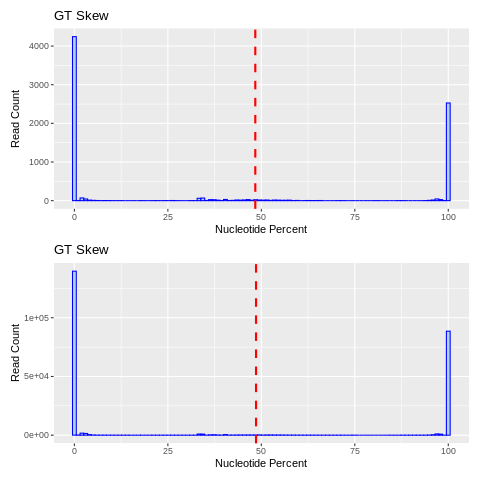

In [ ]:
%%R

# Install and load necessary packages
install.packages(c("ggplot2", "tidyverse", "patchwork"))
library(ggplot2)
library(tidyverse)
library(patchwork)

# List all CSV files in the directory
temp <- list.files(pattern="*.csv")

# Read all CSV files and assign them to separate data frames
data_list <- lapply(setNames(temp, make.names(gsub(".csv$", "", temp))), function(file) {
  # Try reading the CSV file
  df <- tryCatch(read.csv(file, header = TRUE), error = function(e) {
    warning(paste("Error reading", file, ":", e))
    return(NULL)  # Return NULL if an error occurs
  })

  # Check if the data frame is not NULL and has expected columns
  if (!is.null(df) && all(c('AT') %in% colnames(df))) {
    colnames(df) <- c('ID','Sequence','A','C','G','T','AT','AC','AG','CT','CG','GT','LongPat','LongCount','MaxPat','MaxCount','TotalPat','LongLength')
    return(df)
  } else {
    warning(paste("Invalid data frame:", file))
    return(NULL)  # Return NULL if the data frame is invalid
  }
})

# Filter out NULL data frames
data_list <- Filter(Negate(is.null), data_list)

# Plot histograms for AT column of all data frames
histograms <- lapply(data_list, function(df) {
  ggplot(df, aes(x = GT)) +
    ggtitle("GT Skew") +
    xlab("Nucleotide Percent") +
    ylab("Read Count") +
    geom_histogram(color = 'blue', fill = 'lightblue', bins = 100) +
    geom_vline(aes(xintercept = mean(AT)), color = "red", linetype = "dashed", linewidth = 1)
})

# Combine plots using patchwork
combined_plot <- wrap_plots(histograms, ncol = 1)

# Display combined plot
print(combined_plot)

